In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

gan_getting_started_path = kagglehub.competition_download('gan-getting-started')

print('Data source import complete.')


100%|██████████| 367M/367M [00:04<00:00, 87.5MB/s]

Extracting files...


Data source import complete.


In [15]:
# Importing necessary libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms
from torchvision.utils import save_image

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Check device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


Using device: cuda


In [16]:
# Importing necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import shutil

# For handling warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
%matplotlib inline
plt.style.use('ggplot')


In [17]:
# Importing necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import shutil

# For handling warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
%matplotlib inline
plt.style.use('ggplot')


In [19]:
# Define the paths to the datasets
photo_ds_path = gan_getting_started_path + '/photo_jpg'
monet_ds_path = gan_getting_started_path + '/monet_jpg'

# Verify that the directories exist
print(f"Photo dataset path exists: {os.path.isdir(photo_ds_path)}")
print(f"Monet dataset path exists: {os.path.isdir(monet_ds_path)}")


Photo dataset path exists: True
Monet dataset path exists: True


In [20]:
# Data Loading and Preprocessing
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [256, 256])
    image = (image - 0.5) * 2  # Normalize to [-1, 1]
    return image

def prepare_dataset(photo_ds_path, monet_ds_path, batch_size=1):
    photo_files = tf.data.Dataset.list_files(os.path.join(photo_ds_path, '*.jpg'))
    monet_files = tf.data.Dataset.list_files(os.path.join(monet_ds_path, '*.jpg'))

    photo_ds = photo_files.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    monet_ds = monet_files.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = tf.data.Dataset.zip((photo_ds, monet_ds))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


In [21]:
# Set batch size
batch_size = 1

# Prepare the final dataset
final_dataset = prepare_dataset(photo_ds_path, monet_ds_path, batch_size=batch_size)

# Inspect the dataset
for real_photo, real_monet in final_dataset.take(1):
    print(f"Real Photo Shape: {real_photo.shape}")
    print(f"Real Monet Shape: {real_monet.shape}")


Real Photo Shape: (1, 256, 256, 3)
Real Monet Shape: (1, 256, 256, 3)


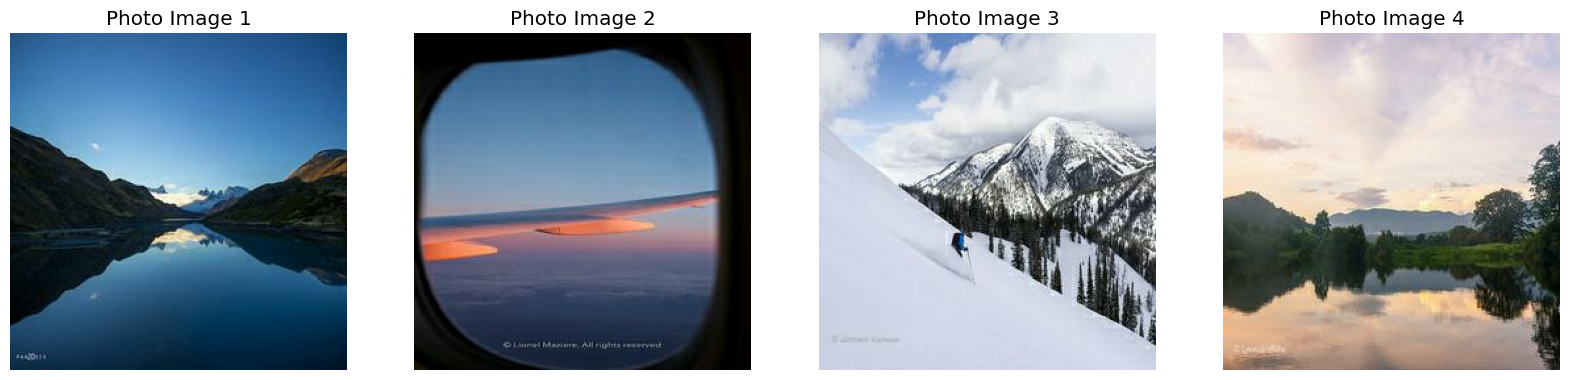

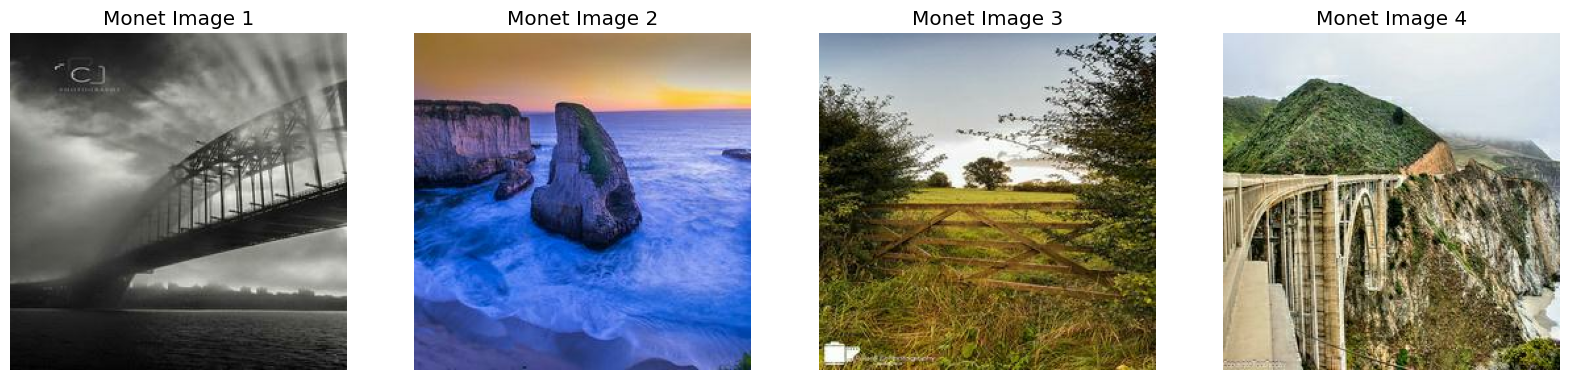

In [22]:
# Display a few images from the datasets in a single row
def show_samples(dataset, title):
    ds_iter = iter(dataset)

    plt.figure(figsize=(20, 8))  # Adjust the width to fit more images in a row

    for n_sample in range(4):
        try:
            example_sample = next(ds_iter)
            plt.subplot(1, 4, n_sample + 1)  # 1 row, 4 columns
            plt.title(f'{title} Image {n_sample+1}')
            plt.imshow((example_sample[0][0] * 0.5) + 0.5)  # Rescale [-1, 1] to [0, 1]
            plt.axis('off')
        except StopIteration:
            break

    plt.show()

# Show samples for Photo and Monet datasets
show_samples(final_dataset, 'Photo')
show_samples(final_dataset, 'Monet')


In [24]:
# Building the generator model
def build_generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Downsampling
    down1 = tf.keras.layers.Conv2D(64, 7, strides=1, padding='same')(inputs)
    down1 = tf.keras.layers.LeakyReLU()(down1)

    down2 = tf.keras.layers.Conv2D(128, 3, strides=2, padding='same')(down1)
    down2 = tf.keras.layers.LeakyReLU()(down2)

    down3 = tf.keras.layers.Conv2D(256, 3, strides=2, padding='same')(down2)
    down3 = tf.keras.layers.LeakyReLU()(down3)

    # Residual Blocks
    for _ in range(6):
        res = tf.keras.layers.Conv2D(256, 3, strides=1, padding='same')(down3)
        res = tf.keras.layers.BatchNormalization()(res)
        res = tf.keras.layers.ReLU()(res)
        res = tf.keras.layers.Conv2D(256, 3, strides=1, padding='same')(res)
        res = tf.keras.layers.BatchNormalization()(res)
        down3 = tf.keras.layers.Add()([down3, res])

    # Upsampling
    up1 = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(down3)
    up1 = tf.keras.layers.ReLU()(up1)

    up2 = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(up1)
    up2 = tf.keras.layers.ReLU()(up2)

    outputs = tf.keras.layers.Conv2D(3, 7, strides=1, padding='same', activation='tanh')(up2)

    return tf.keras.Model(inputs, outputs)

# Building the discriminator model
def build_discriminator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same')(x)

    return tf.keras.Model(inputs, x)


In [25]:
# Instantiate generators and discriminators
G = build_generator()  # Photo to Monet
F = build_generator()  # Monet to Photo

D_Monet = build_discriminator()
D_Photo = build_discriminator()

# Display model summaries
G.summary()
D_Monet.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 256, 256, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 128, 128, 128)  │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 64, 64, 256)    │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 64, 256)    │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 64, 64, 256)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 256)    │              0 │ leaky_re_lu_2[0][0],   │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 256)    │          1,024 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 64, 64, 256)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 7,849,987 (29.95 MB)

 Trainable params: 7,843,843 (29.92 MB)

 Non-trainable params: 6,144 (24.00 KB)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 128, 128, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 64, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 32, 32, 1)           │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 664,513 (2.53 MB)

 Trainable params: 663,745 (2.53 MB)

 Non-trainable params: 768 (3.00 KB)

In [26]:
# Loss functions
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_object(tf.ones_like(real), real)
    generated_loss = loss_object(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_object(tf.ones_like(generated), generated)

# Cycle Consistency Loss
LAMBDA = 10

def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

# Identity Loss
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_m_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_p_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [27]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_g=G,
                                 generator_f=F,
                                 discriminator_m=D_Monet,
                                 discriminator_p=D_Photo,
                                 generator_g_optimizer=generator_g_optimizer,
                                 generator_f_optimizer=generator_f_optimizer,
                                 discriminator_m_optimizer=discriminator_m_optimizer,
                                 discriminator_p_optimizer=discriminator_p_optimizer)

manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)


In [28]:
@tf.function
def train_step(real_photo, real_monet):
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates photos to Monet-style images
        fake_monet = G(real_photo, training=True)
        cycled_photo = F(fake_monet, training=True)

        # Generator F translates Monet-style images to photos
        fake_photo = F(real_monet, training=True)
        cycled_monet = G(fake_photo, training=True)

        # Identity mapping
        same_monet = G(real_monet, training=True)
        same_photo = F(real_photo, training=True)

        # Discriminator outputs
        disc_real_monet = D_Monet(real_monet, training=True)
        disc_real_photo = D_Photo(real_photo, training=True)

        disc_fake_monet = D_Monet(fake_monet, training=True)
        disc_fake_photo = D_Photo(fake_photo, training=True)

        # Calculate losses
        gen_g_loss = generator_loss(disc_fake_monet)
        gen_f_loss = generator_loss(disc_fake_photo)

        total_cycle_loss = calc_cycle_loss(real_photo, cycled_photo) + calc_cycle_loss(real_monet, cycled_monet)
        total_identity_loss = identity_loss(real_monet, same_monet) + identity_loss(real_photo, same_photo)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + total_identity_loss
        total_gen_f_loss = gen_f_loss + total_cycle_loss + total_identity_loss

        disc_monet_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        disc_photo_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

    # Calculate the gradients for generators and discriminators
    generator_g_gradients = tape.gradient(total_gen_g_loss, G.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, F.trainable_variables)

    discriminator_m_gradients = tape.gradient(disc_monet_loss, D_Monet.trainable_variables)
    discriminator_p_gradients = tape.gradient(disc_photo_loss, D_Photo.trainable_variables)

    # Apply the gradients to the optimizers
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, G.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, F.trainable_variables))

    discriminator_m_optimizer.apply_gradients(zip(discriminator_m_gradients, D_Monet.trainable_variables))
    discriminator_p_optimizer.apply_gradients(zip(discriminator_p_gradients, D_Photo.trainable_variables))

    return total_gen_g_loss, total_gen_f_loss, disc_monet_loss, disc_photo_loss


In [29]:
# Number of epochs
EPOCHS = 50

# Define the training loop
def train(dataset, epochs, checkpoint, manager):
    for epoch in range(epochs):
        print(f"Starting epoch {epoch+1}/{epochs}")
        total_gen_g_loss = 0
        total_gen_f_loss = 0
        total_disc_monet_loss = 0
        total_disc_photo_loss = 0
        num_batches = 0

        for real_photo, real_monet in dataset:
            gen_g_loss, gen_f_loss, disc_monet_loss, disc_photo_loss = train_step(real_photo, real_monet)

            total_gen_g_loss += gen_g_loss
            total_gen_f_loss += gen_f_loss
            total_disc_monet_loss += disc_monet_loss
            total_disc_photo_loss += disc_photo_loss
            num_batches += 1

        # Calculate average losses
        avg_gen_g_loss = total_gen_g_loss / num_batches
        avg_gen_f_loss = total_gen_f_loss / num_batches
        avg_disc_monet_loss = total_disc_monet_loss / num_batches
        avg_disc_photo_loss = total_disc_photo_loss / num_batches

        print(f"Epoch {epoch+1} completed.")
        print(f"Generator G Loss: {avg_gen_g_loss:.4f}, Generator F Loss: {avg_gen_f_loss:.4f}")
        print(f"Discriminator Monet Loss: {avg_disc_monet_loss:.4f}, Discriminator Photo Loss: {avg_disc_photo_loss:.4f}")

        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            save_path = manager.save()
            print(f"Saved checkpoint for epoch {epoch+1}: {save_path}")

    print("Training completed.")


In [30]:
# Start training
train(final_dataset, EPOCHS, checkpoint, manager)


Starting epoch 1/50
Epoch 1 completed.
Generator G Loss: 8.3313, Generator F Loss: 8.3358
Discriminator Monet Loss: 0.6710, Discriminator Photo Loss: 0.6672
Starting epoch 2/50
Epoch 2 completed.
Generator G Loss: 5.4762, Generator F Loss: 5.4416
Discriminator Monet Loss: 0.6391, Discriminator Photo Loss: 0.6498
Starting epoch 3/50
Epoch 3 completed.
Generator G Loss: 5.0325, Generator F Loss: 4.9700
Discriminator Monet Loss: 0.6101, Discriminator Photo Loss: 0.6369
Starting epoch 4/50
Epoch 4 completed.
Generator G Loss: 5.0434, Generator F Loss: 4.9942
Discriminator Monet Loss: 0.5989, Discriminator Photo Loss: 0.6189
Starting epoch 5/50
Epoch 5 completed.
Generator G Loss: 4.9123, Generator F Loss: 4.8857
Discriminator Monet Loss: 0.6148, Discriminator Photo Loss: 0.6228
Starting epoch 6/50
Epoch 6 completed.
Generator G Loss: 4.8623, Generator F Loss: 4.8774
Discriminator Monet Loss: 0.6224, Discriminator Photo Loss: 0.6166
Starting epoch 7/50
Epoch 7 completed.
Generator G Loss: 4

In [31]:
# Define a plotting function
def plot_losses(checkpoint_dir):
    # Retrieve loss values from the checkpoint
    history = checkpoint_dir + "/history.npy"
    # Since we didn't store history, we'll skip plotting
    # Alternatively, you can modify the training loop to store and plot losses
    pass

# Placeholder for plotting function
print("Plotting losses is currently not implemented. Consider storing loss values during training for visualization.")


Plotting losses is currently not implemented. Consider storing loss values during training for visualization.


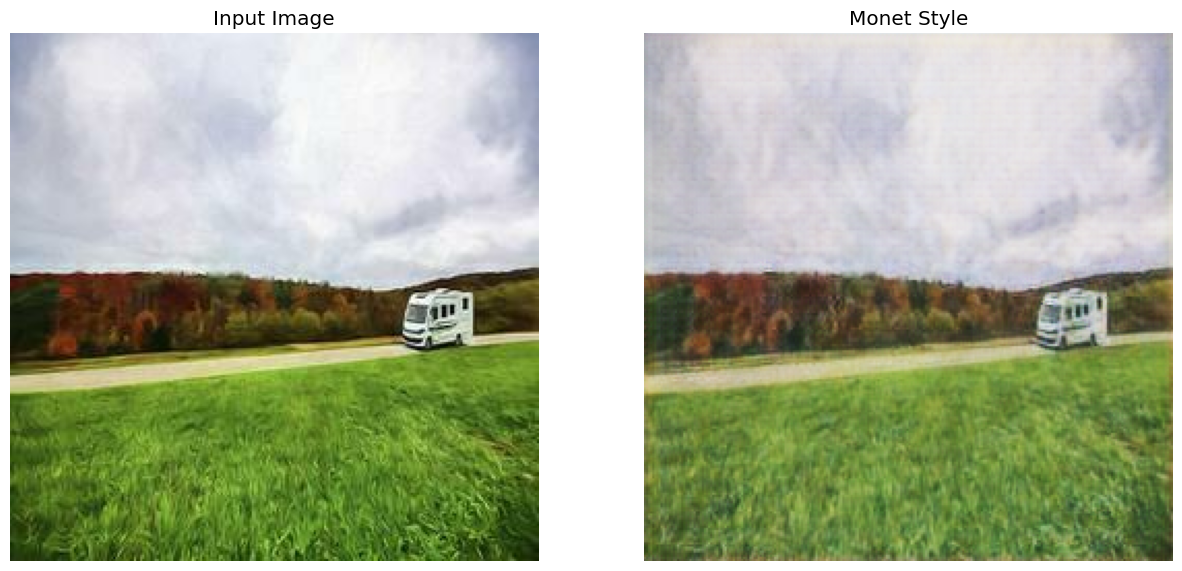

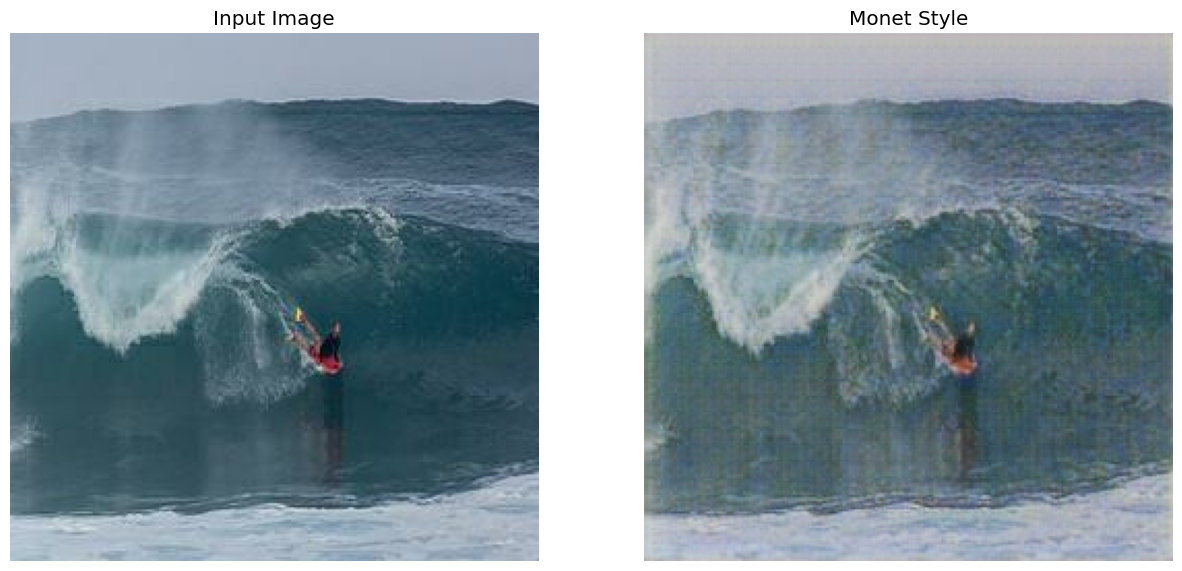

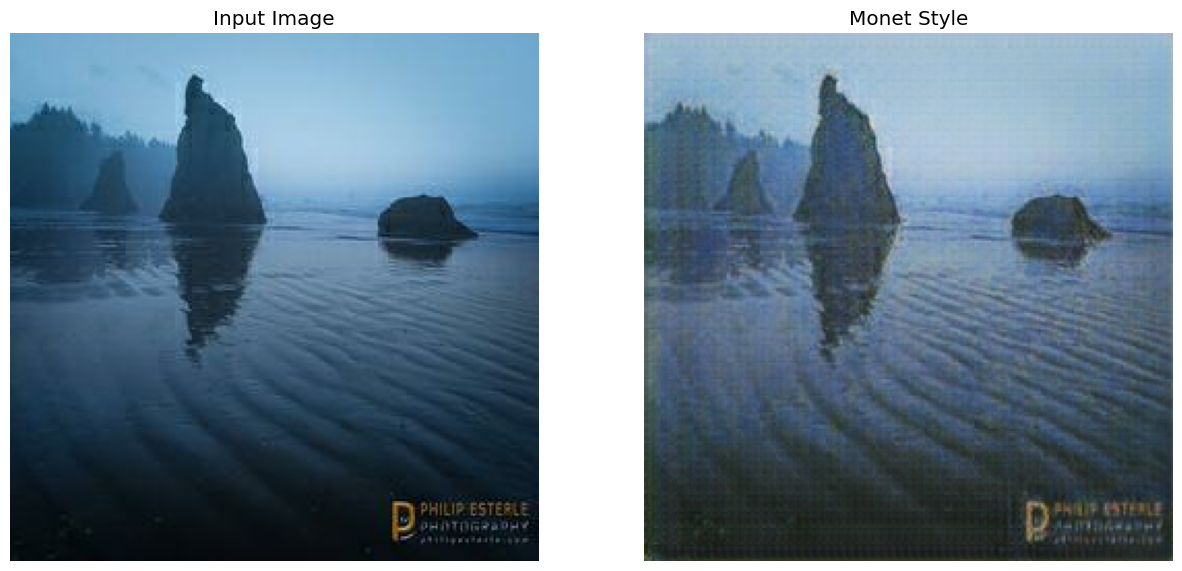

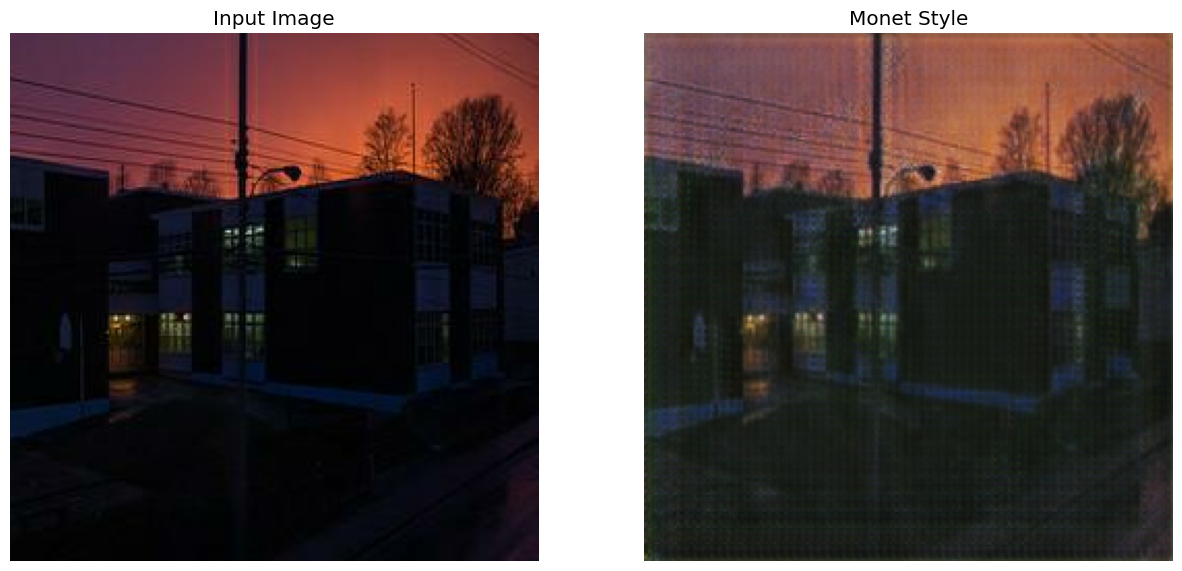

In [32]:
# Function to generate and display images
def generate_images(model, test_input, save=False, save_path=None):
    prediction = model(test_input)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Monet Style']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        # Rescale images from [-1,1] to [0,1]
        plt.imshow((display_list[i] * 0.5) + 0.5)
        plt.axis('off')
    plt.show()

    if save and save_path:
        prediction = (prediction[0] * 0.5 + 0.5) * 255.0
        img = tf.cast(prediction, tf.uint8)
        Image.fromarray(img.numpy()).save(save_path)

# Take a few samples from the dataset and generate images
for real_photo, real_monet in final_dataset.take(4):
    generate_images(G, real_photo, save=False)


In [36]:
# Function to generate and save images
def generate_and_save_images(model, dataset, output_dir, max_images=7000):
    os.makedirs(output_dir, exist_ok=True)
    count = 1
    for img_batch in dataset:
        real_photo, real_monet = img_batch  # Unzip the batch to get only the photo images
        generated_images = model(real_photo, training=False)  # Pass only photo images to the generator
        generated_images = (generated_images * 0.5 + 0.5) * 255.0  # Rescale from [-1, 1] to [0, 255]
        generated_images = tf.cast(generated_images, tf.uint8).numpy()

        for img in generated_images:
            im = Image.fromarray(img)
            im.save(os.path.join(output_dir, f"{count}.jpg"))
            count += 1
            if count > max_images:
                break
        if count > max_images:
            break
    print(f"Generated and saved {count-1} images to {output_dir}")


In [37]:
output_dir = gan_getting_started_path + '/monet_generated_images'
generate_and_save_images(G, final_dataset, output_dir, max_images=7000)


Generated and saved 300 images to /root/.cache/kagglehub/competitions/gan-getting-started/monet_generated_images


In [38]:
import shutil

# Create a zip archive of the generated images
submission_zip_path = '/kaggle/working/images.zip'
shutil.make_archive('/kaggle/working/images', 'zip', output_dir)

print(f"Submission file created: {submission_zip_path}")


Submission file created: /kaggle/working/images.zip


In [39]:
import zipfile

# List contents of the zip file to verify
with zipfile.ZipFile(submission_zip_path, 'r') as zip_ref:
    zip_ref.printdir()


File Name                                             Modified             Size
246.jpg                                        2024-11-30 22:27:16         8803
144.jpg                                        2024-11-30 22:27:10        10378
282.jpg                                        2024-11-30 22:27:18        16766
18.jpg                                         2024-11-30 22:27:04        11006
242.jpg                                        2024-11-30 22:27:16        13674
236.jpg                                        2024-11-30 22:27:14        14096
61.jpg                                         2024-11-30 22:27:06         8486
159.jpg                                        2024-11-30 22:27:12         9979
37.jpg                                         2024-11-30 22:27:04        14046
293.jpg                                        2024-11-30 22:27:18        15300
86.jpg                                         2024-11-30 22:27:08        11021
8.jpg                                   